In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import wandb
from datetime import datetime
from tqdm.notebook import tqdm

def download_model_residuals():
    api = wandb.Api()

    filters = {
        "$and": [
            {"config.train_dataset": {"$nin": ["src", "bpm10_src", "bike11_src"]}}
        ]
    }

    runs = api.runs("transfer-learning-tcn/tcn_custom_loss_residuals",
                    filters=filters,
                    order="-created_at")

    config_list = []
    residuals = dict()
    for run in tqdm(runs):
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary = {k: v for k, v in run.summary._json_dict.items()
                   if not k.startswith('_') and
                   not type(v) is list and
                   not type(v) is dict}
        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        conf = {k: v for k,v in run.config.items()
                if not k.startswith('_')}
        conf.update(summary)
        conf['timestamp'] = run.summary['_timestamp']
        conf['wandb_name'] = run.name
        config_list.append(conf)
        # .name is the human-readable name of the run.
        # name_list.append(run.name)
        res = wandb.restore('test_test_residuals.npy', run_path="/".join(run.path), replace=True)
        residuals[run.name] = np.load(res.name)

    residuals = residuals
    runs_df = pd.DataFrame(config_list)
    return runs_df, residuals

In [3]:
download = False
if download:
    residual_df, residuals = download_model_residuals()
    # save wandb downloaded data
    np.savez("tcn_custom_loss_residuals", **residuals)
    residual_df.to_csv("tcn_custom_loss_residuals.csv")
else:
    residual_df = pd.read_csv("tcn_custom_loss_residuals.csv")
    residuals = np.load("tcn_custom_loss_residuals.npz", allow_pickle=True)

In [4]:
def approach_rename(inputs):
    proc_inputs = "_".join([str(n).upper() for n in inputs])
    name_convertion = dict(
        MSE_MEE='MSE-MEE',
        MEE_MEE='MEE-MEE',
        MI_MSE='MI-MSE',
        MSE_MSE='MSE-MSE',
        MEE_MSE='MEE-MSE',
        NAN_MI='baseline MI',
        NAN_MSE='baseline MSE',
        NAN_MEE='baseline MEE'
    )
    return name_convertion[proc_inputs]

In [5]:
# wandb_data = pd.read_csv('wandb_exports/tcn_custom_loss_all_results_boxplot.csv')
# wandb_data['approach'] = wandb_data[['loss_src', 'loss_function']].apply(approach_rename, axis=1)
residual_df['approach'] = residual_df[['loss_src', 'loss_function']].apply(approach_rename, axis=1)

In [6]:
residual_df['approach'].value_counts()

baseline MEE    105
baseline MSE    105
MSE-MSE         100
MSE-MEE         100
MEE-MSE         100
MEE-MEE         100
Name: approach, dtype: int64

In [7]:
# wandb_data = residual_df

In [8]:
def merge_residuals_and_metadata(df, res_dict, filter=None):
    if filter is not None:
        df = df[filter]
    res_list = [res_dict[name] for name in df['wandb_name']]
    lengths = [len(x) for x in res_list]
    meta = np.repeat(np.array(df[['approach', 'train_dataset']]), lengths, axis=0)
    res_np = np.concatenate(res_list)
    merged = pd.DataFrame(np.concatenate([meta, res_np], axis=1), columns=['approach', 'train_dataset', 'residuals'])
    merged.sort_values(by=['approach'])
    return merged

In [9]:
def filter_approaches(dataframe, dataset='tar1', approaches=[]):
    filter = dataframe['train_dataset'].str.contains(dataset)
    if len(approaches) == 0:
        return filter
    ap_filter = [False for _ in range(len(filter))]
    for ap in approaches:
        ap_filter = ap_filter | dataframe['approach'].str.contains(ap)
    return filter & ap_filter

In [10]:
sns.set_context('talk')
sns.set_style('whitegrid')
def plot_boxplots(wandb_df, dataset_name):
    filter_df = wandb_df[wandb_df['train_dataset'].str.contains(dataset_name)]

    fig, axes = plt.subplots(1, 2, figsize=(24,10))
    sns.boxplot(
        x='approach', y='test/mse',
        data=filter_df.sort_values('approach'),
        ax=axes[0],
        showmeans=True,
        meanprops={"marker": "x", "markeredgecolor": "black"})
    sns.boxplot(
        x='approach', y='test/mae',
        data=filter_df.sort_values('approach'),
        ax=axes[1],
        showmeans=True,
        meanprops={"marker": "x", "markeredgecolor": "black"})
    for i, ax in enumerate(axes):
        plt.sca(ax)
        plt.xticks(rotation=45, ha='right')
        plt.xlabel("Train/finetune loss function")
        if i == 0:
            plt.ylabel("Test MSE")
        else:
            plt.ylabel("Test MAE")
    plt.tight_layout()
    plt.savefig(f"plots/{dataset_name}_boxplots.png")

def plot_histograms(wandb_df, res_dict, dataset_name):
    fig, axes = plt.subplots(1, 2, figsize=(24,10))

    approach_order = ['baseline MEE', 'baseline MSE']
    filter = filter_approaches(wandb_df, dataset=dataset_name, approaches=approach_order)
    merged = merge_residuals_and_metadata(wandb_df, res_dict, filter=filter)
    sns.histplot(data=merged, x='residuals', hue='approach', hue_order=approach_order, ax=axes[0])

    approach_order = ['MSE-MEE', 'MSE-MSE']
    filter = filter_approaches(wandb_df, dataset=dataset_name, approaches=approach_order)
    merged = merge_residuals_and_metadata(wandb_df, res_dict, filter=filter)
    sns.histplot(data=merged, x='residuals', hue='approach', hue_order=approach_order, ax=axes[1])
    plt.tight_layout()
    plt.savefig(f"plots/{dataset_name}_histograms.png")

# CMAPSS target dataset 1

In [11]:
nasa_tar1_filter = residual_df['train_dataset'].str.contains('tar1')
nasa_tar1_results = residual_df[nasa_tar1_filter]
# wandb_data = wandb_data[wandb_data['tcn2'] == False]
# wandb_data = wandb_data[wandb_data['State'] == 'finished']
# nasa_tar1_results = nasa_tar1_results[~nasa_tar1_results['group'].str.contains('src')] # remove source network results

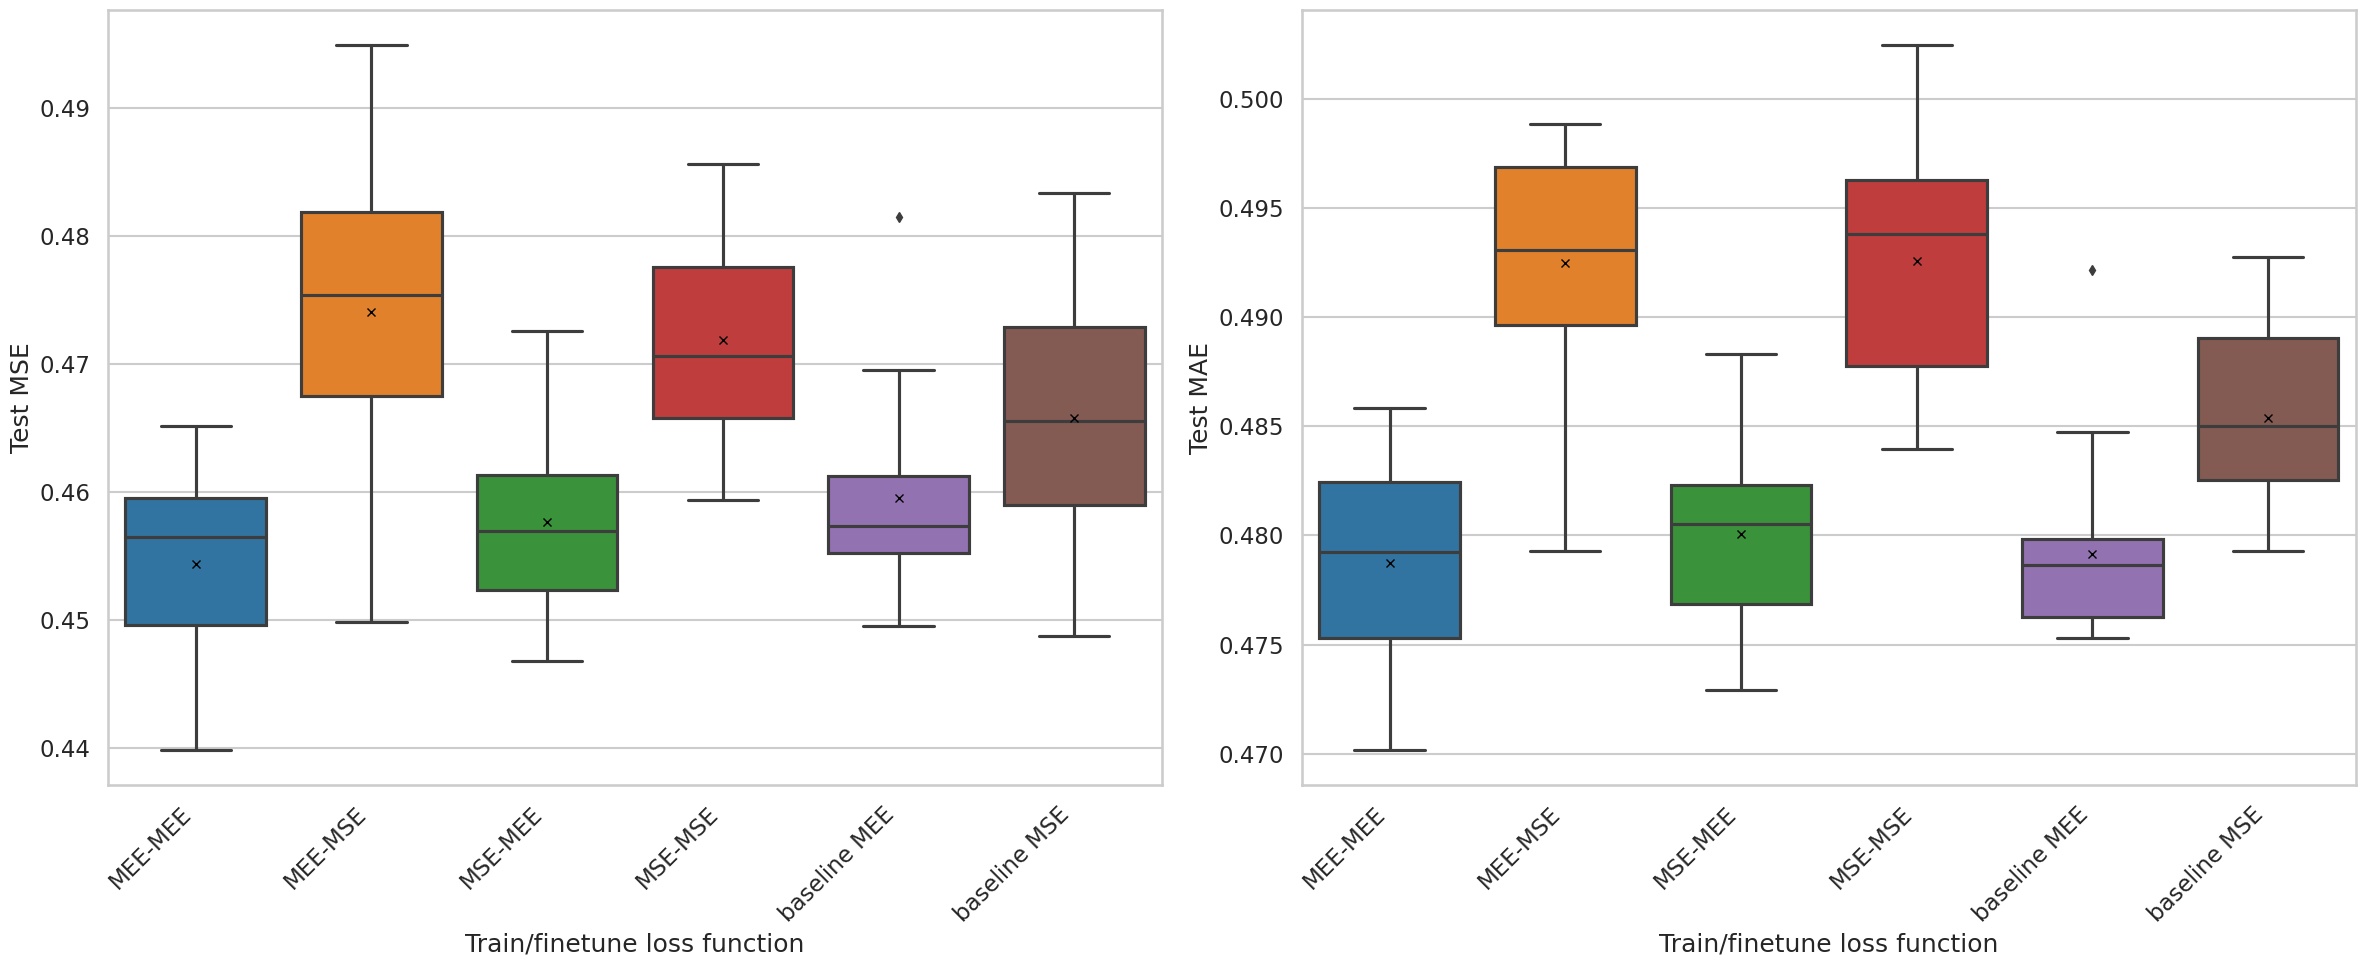

In [12]:
plot_boxplots(residual_df, "tar1")

In [13]:
# nasa_tar1_results.groupby('approach')['test/mse'].agg(['mean', 'std', 'median'])

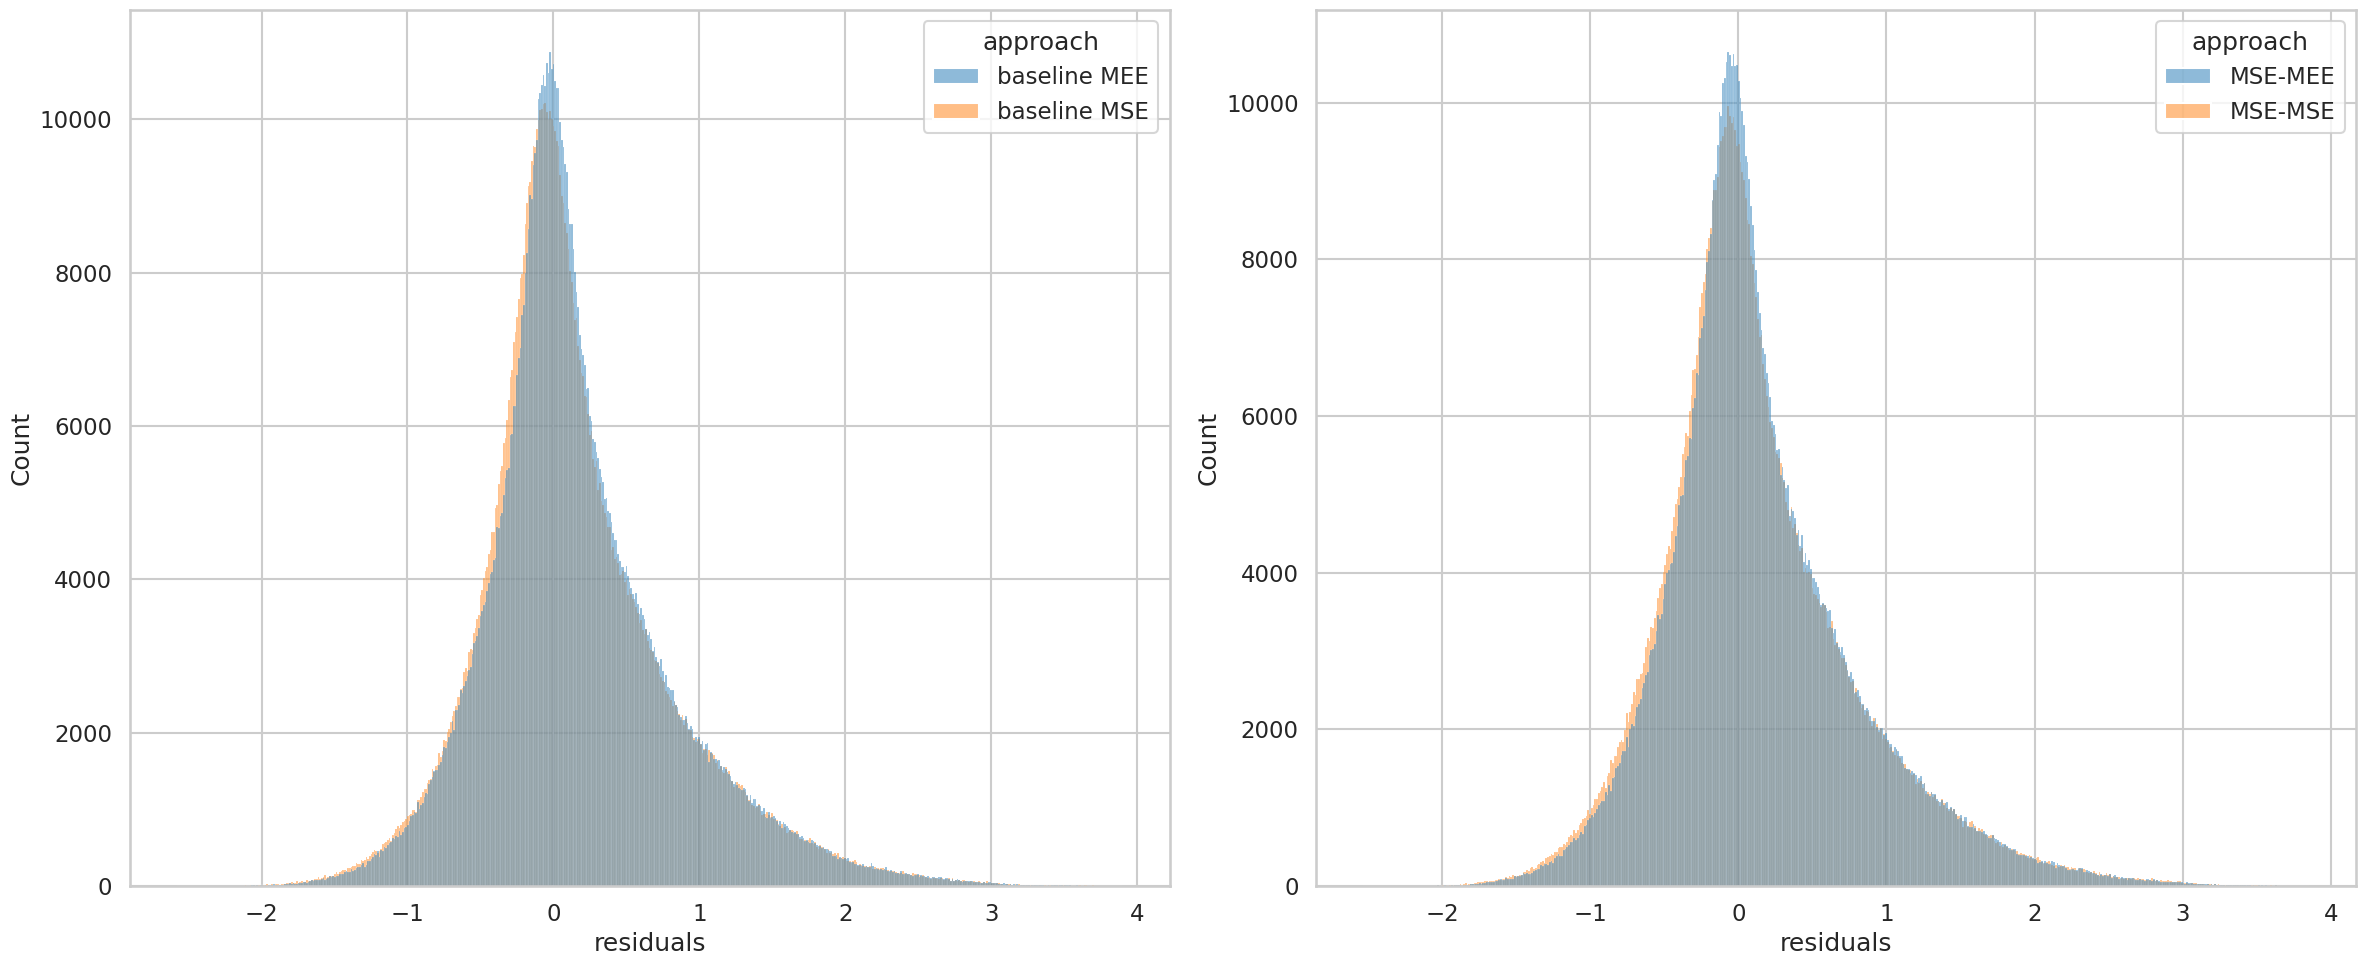

In [14]:
plot_histograms(residual_df, residuals, 'tar1')

----------------------------------------------------------
# CMAPSS target dataset 2

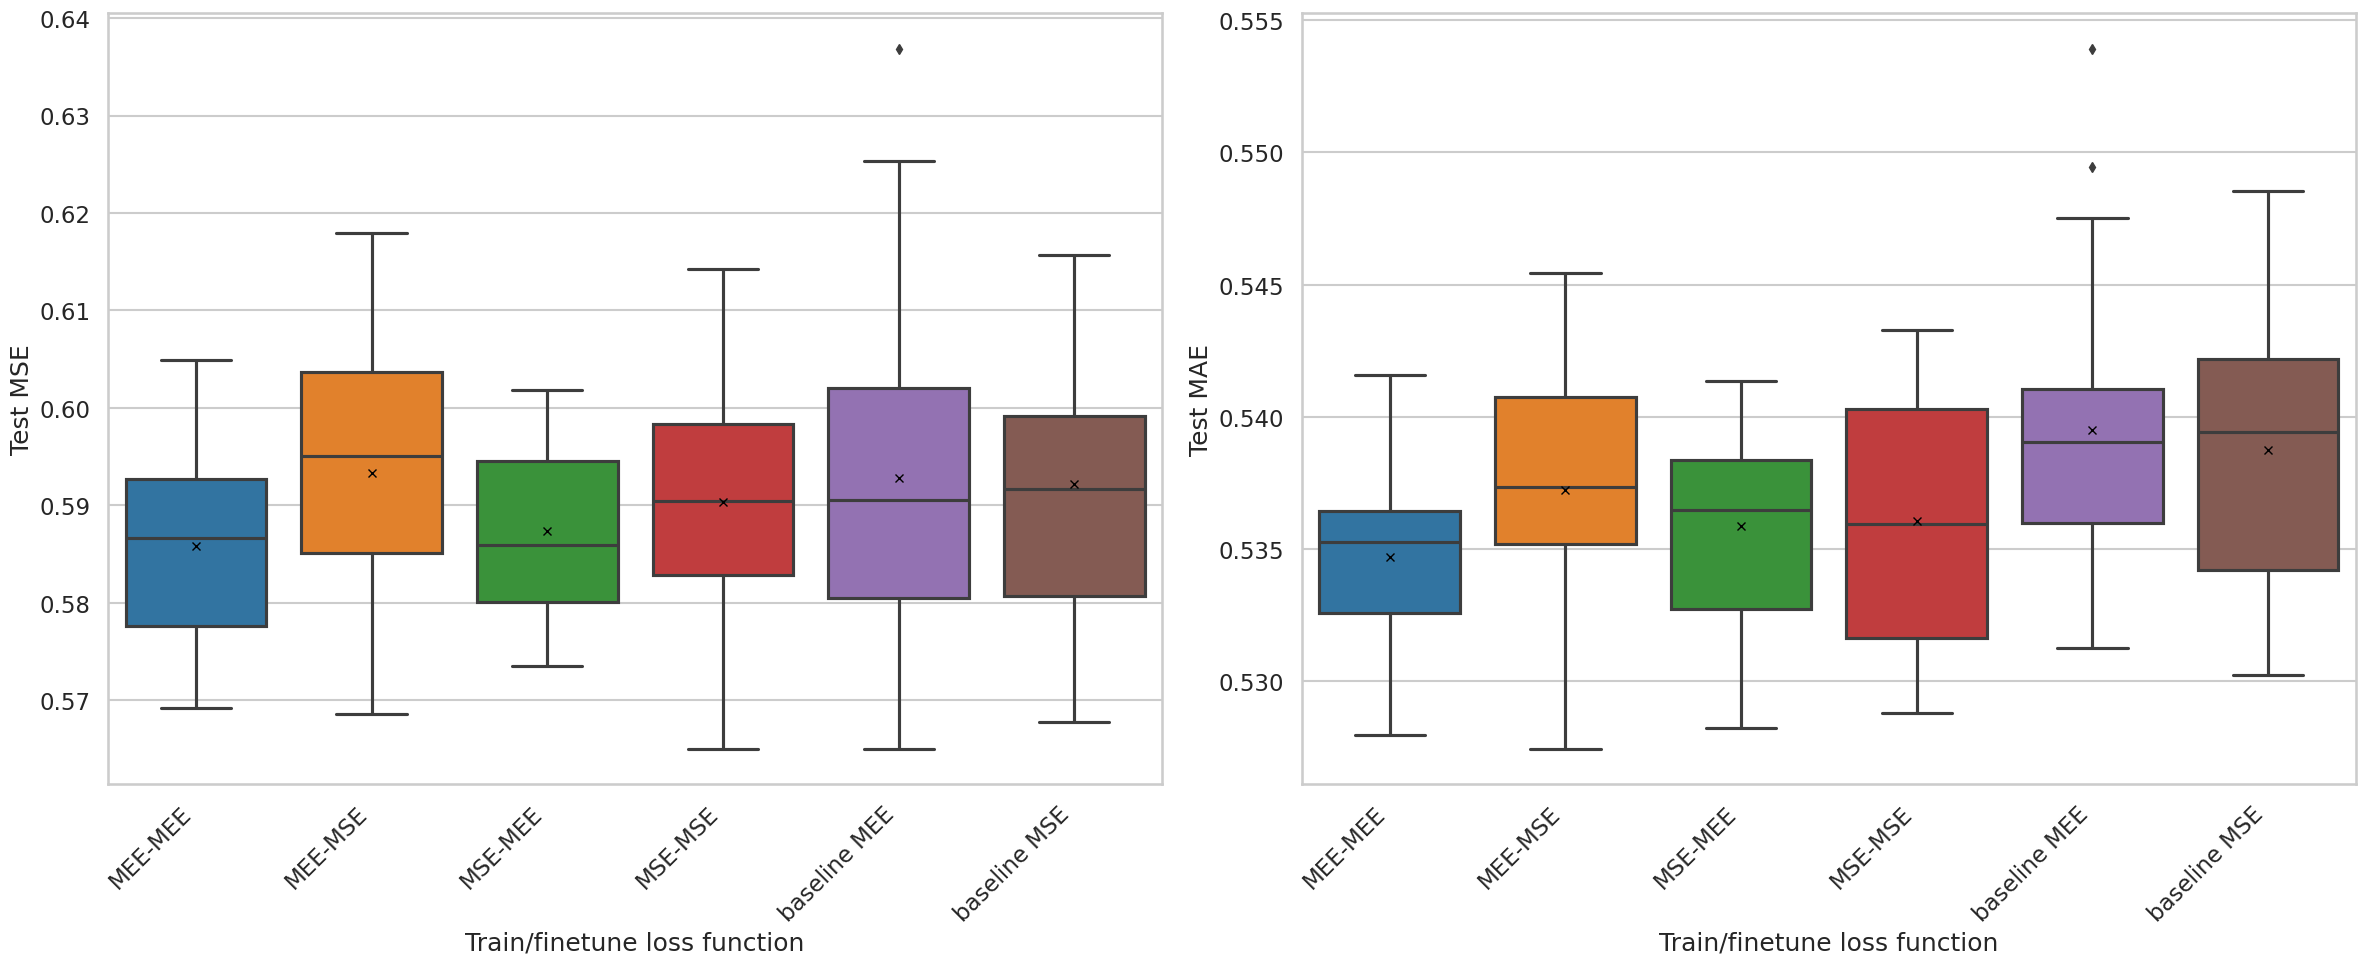

In [15]:
plot_boxplots(residual_df, "tar2")

In [16]:
# nasa_tar2_results.groupby('approach')['test/mse'].agg(['mean', 'std', 'median'])

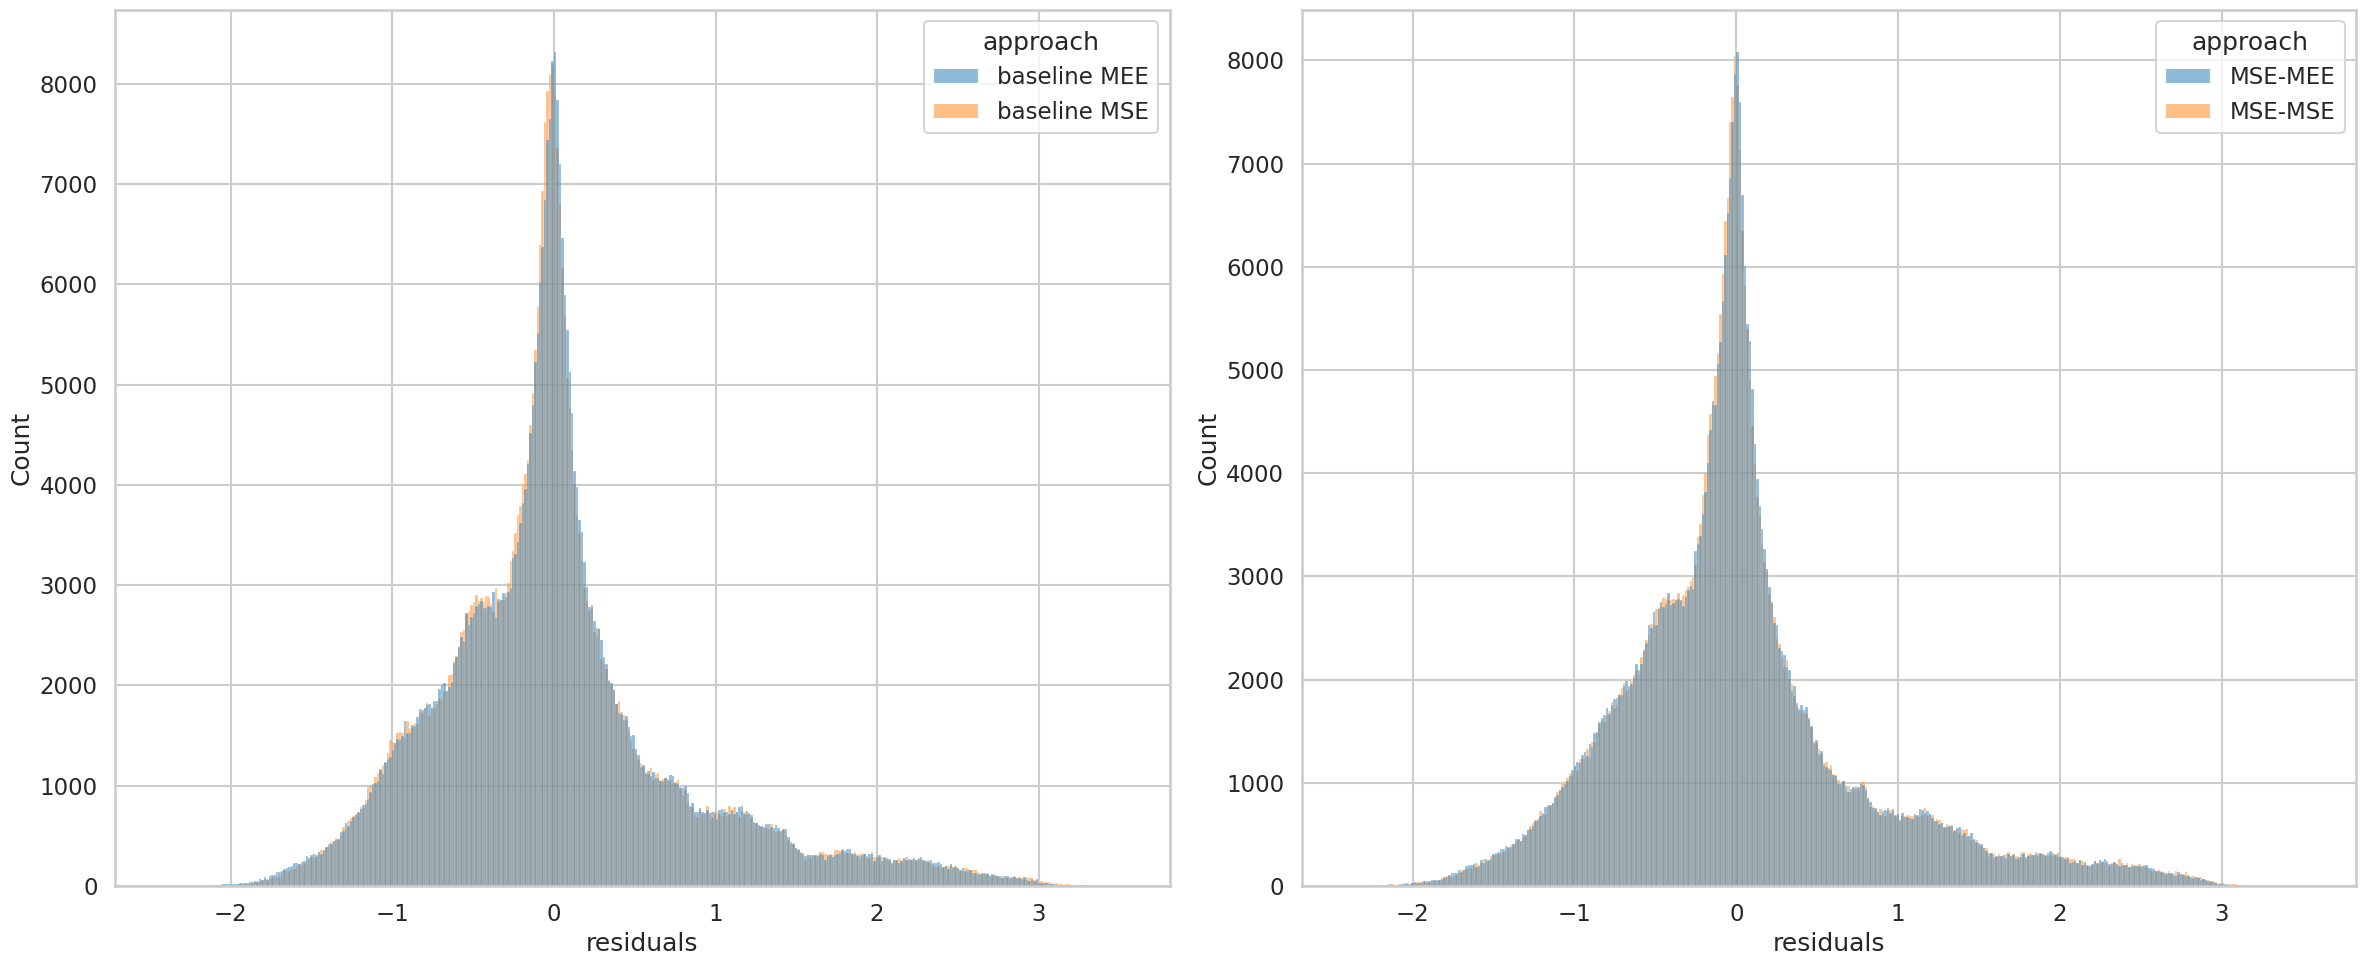

In [17]:
plot_histograms(residual_df, residuals, 'tar2')

------------------
## CMAPSS target dataset 3

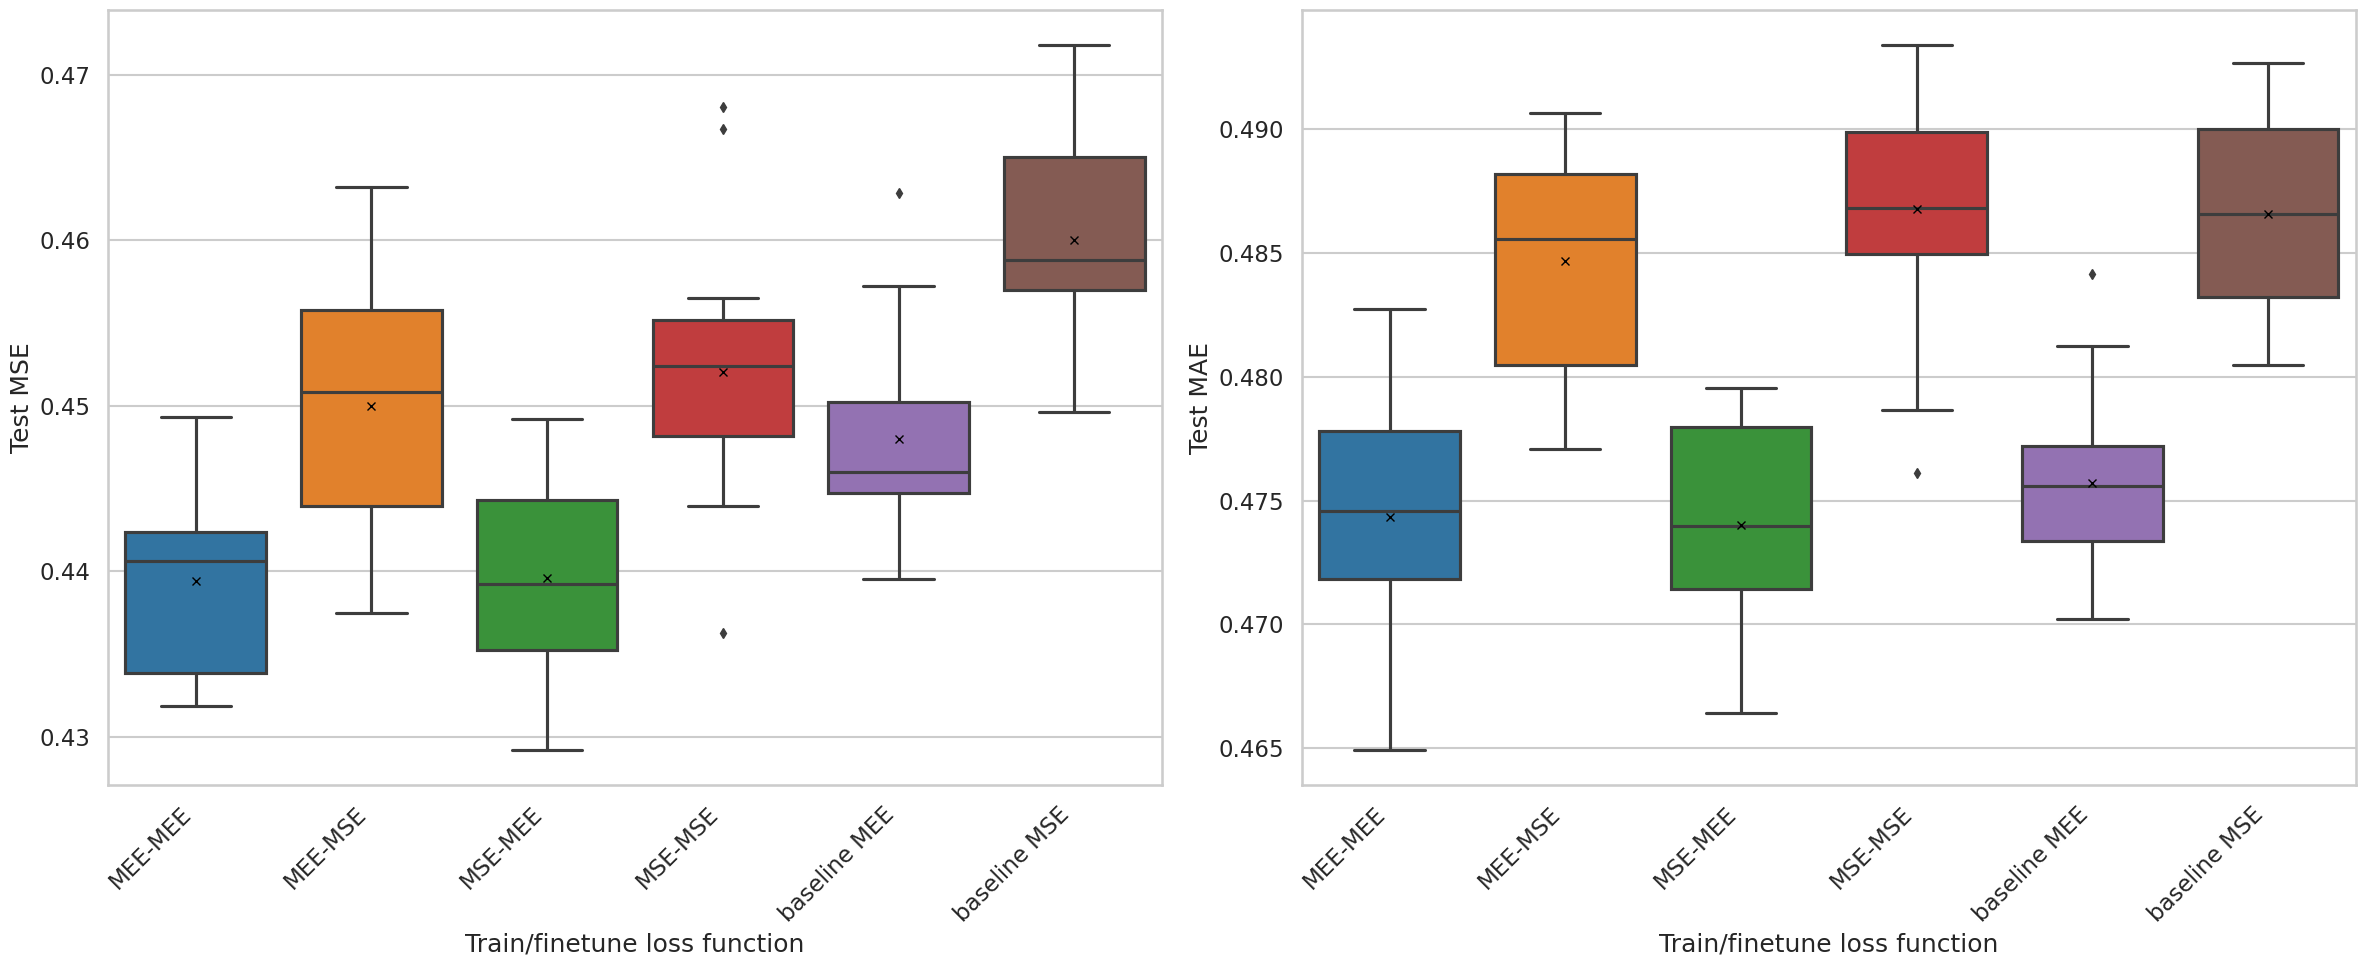

In [18]:
plot_boxplots(residual_df, "tar3")

In [19]:
# nasa_tar3_results = residual_df[residual_df['train_dataset'].str.contains('tar3')]
# nasa_tar3_results.groupby('approach')['test/mse'].agg(['mean', 'std', 'median'])

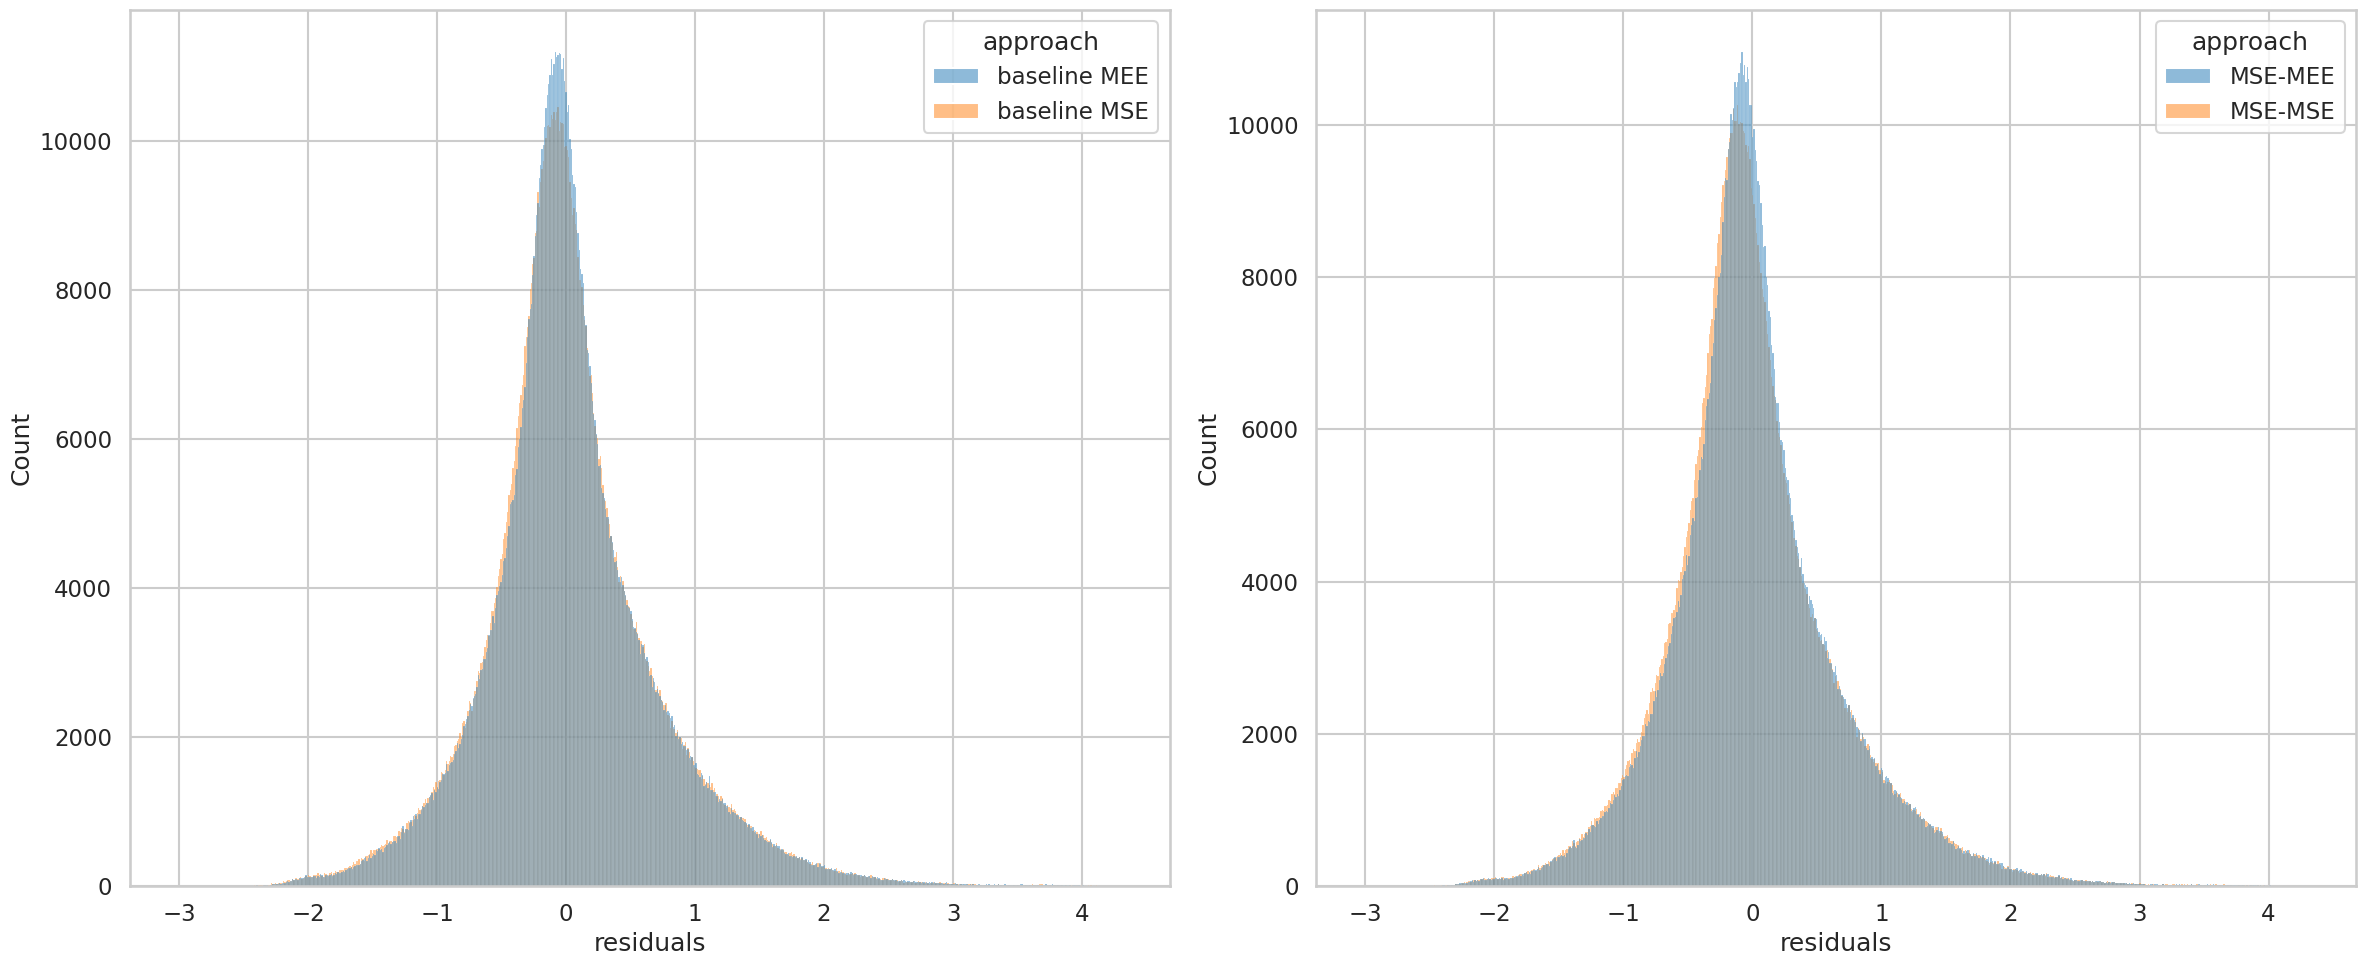

In [20]:
plot_histograms(residual_df, residuals, 'tar3')

------------------
# BPM10 dataset

In [21]:
# bpm10_tar_results = residual_df[residual_df['train_dataset'].str.contains('bpm10')]
# bpm10_tar_results.groupby('approach')['test/mse'].agg(['mean', 'std', 'median'])

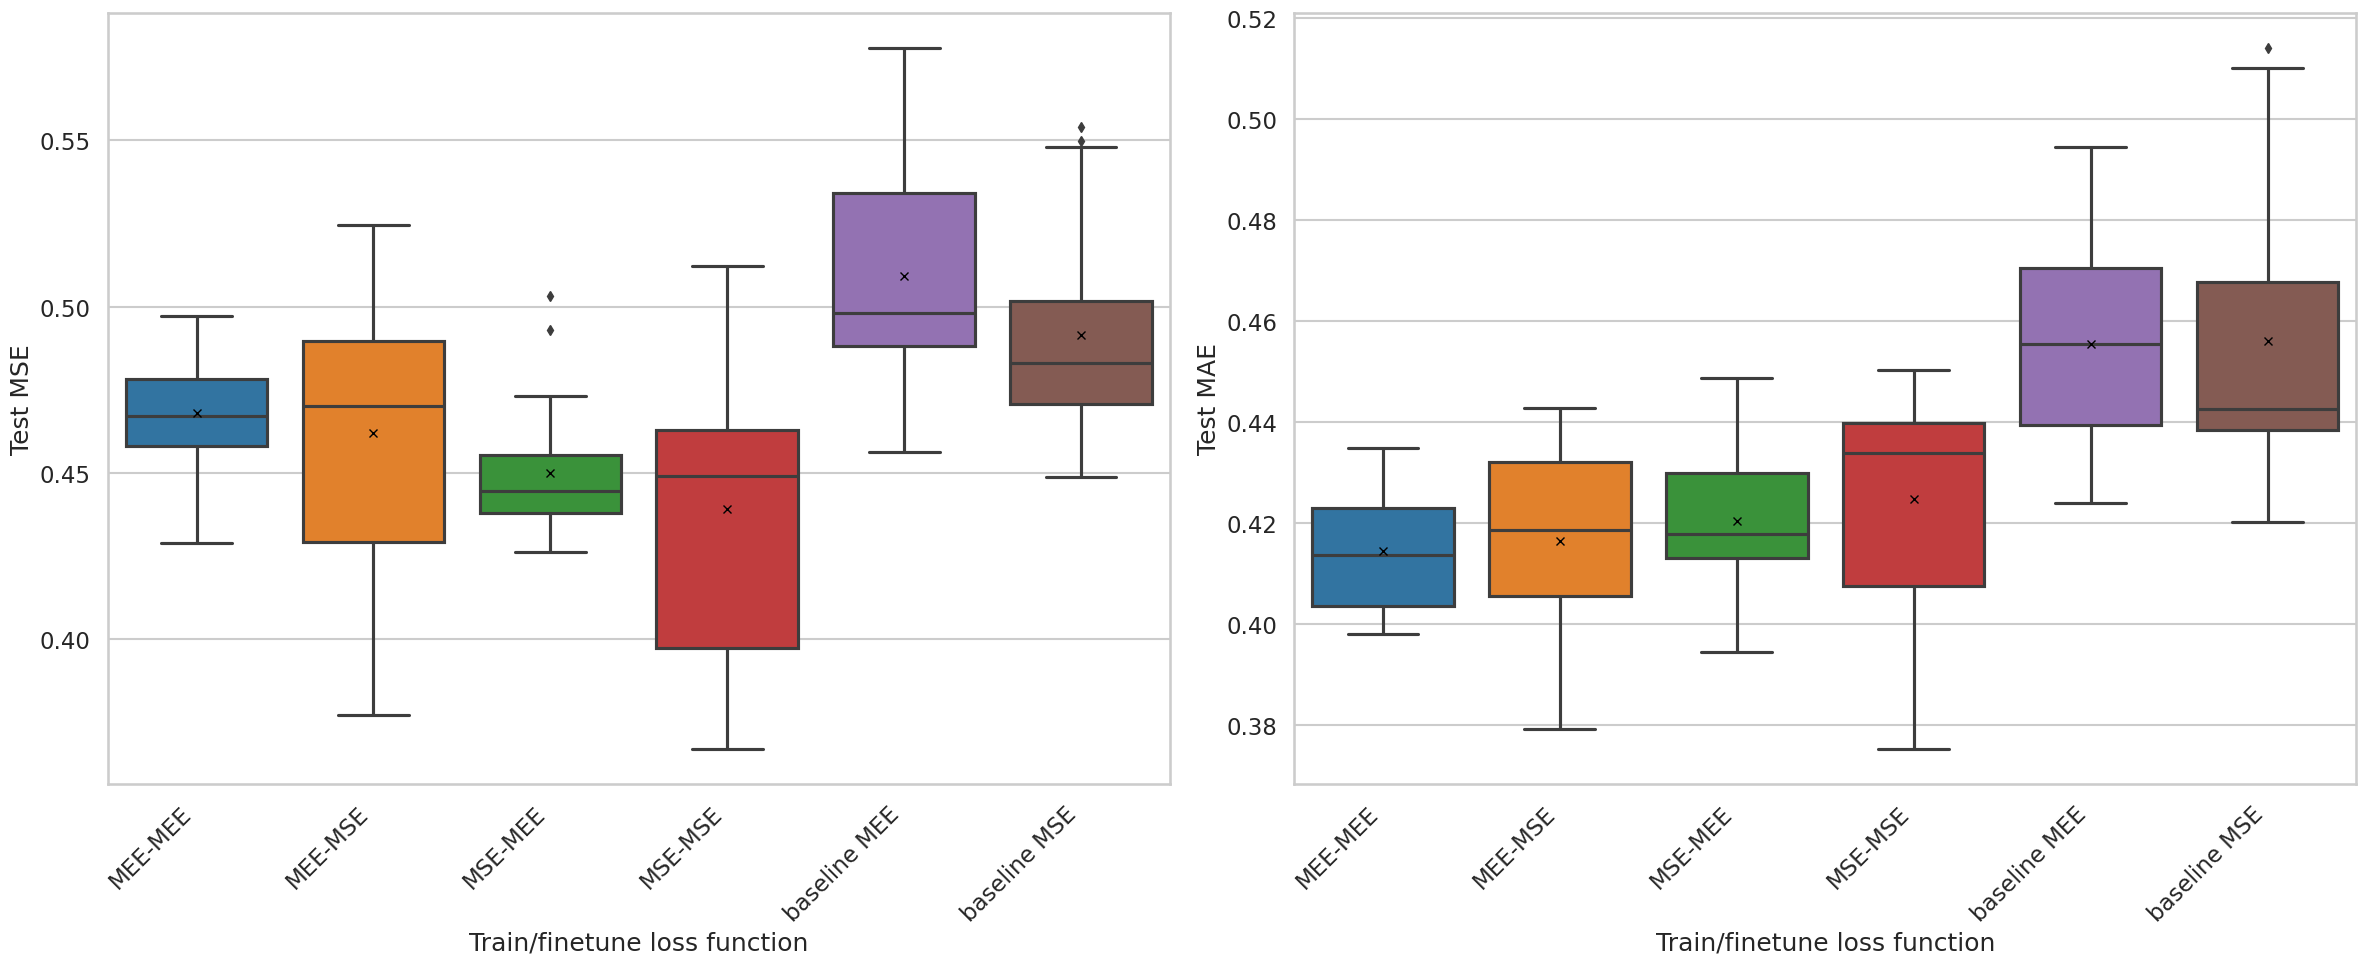

In [22]:
plot_boxplots(residual_df, "bpm10_tar")

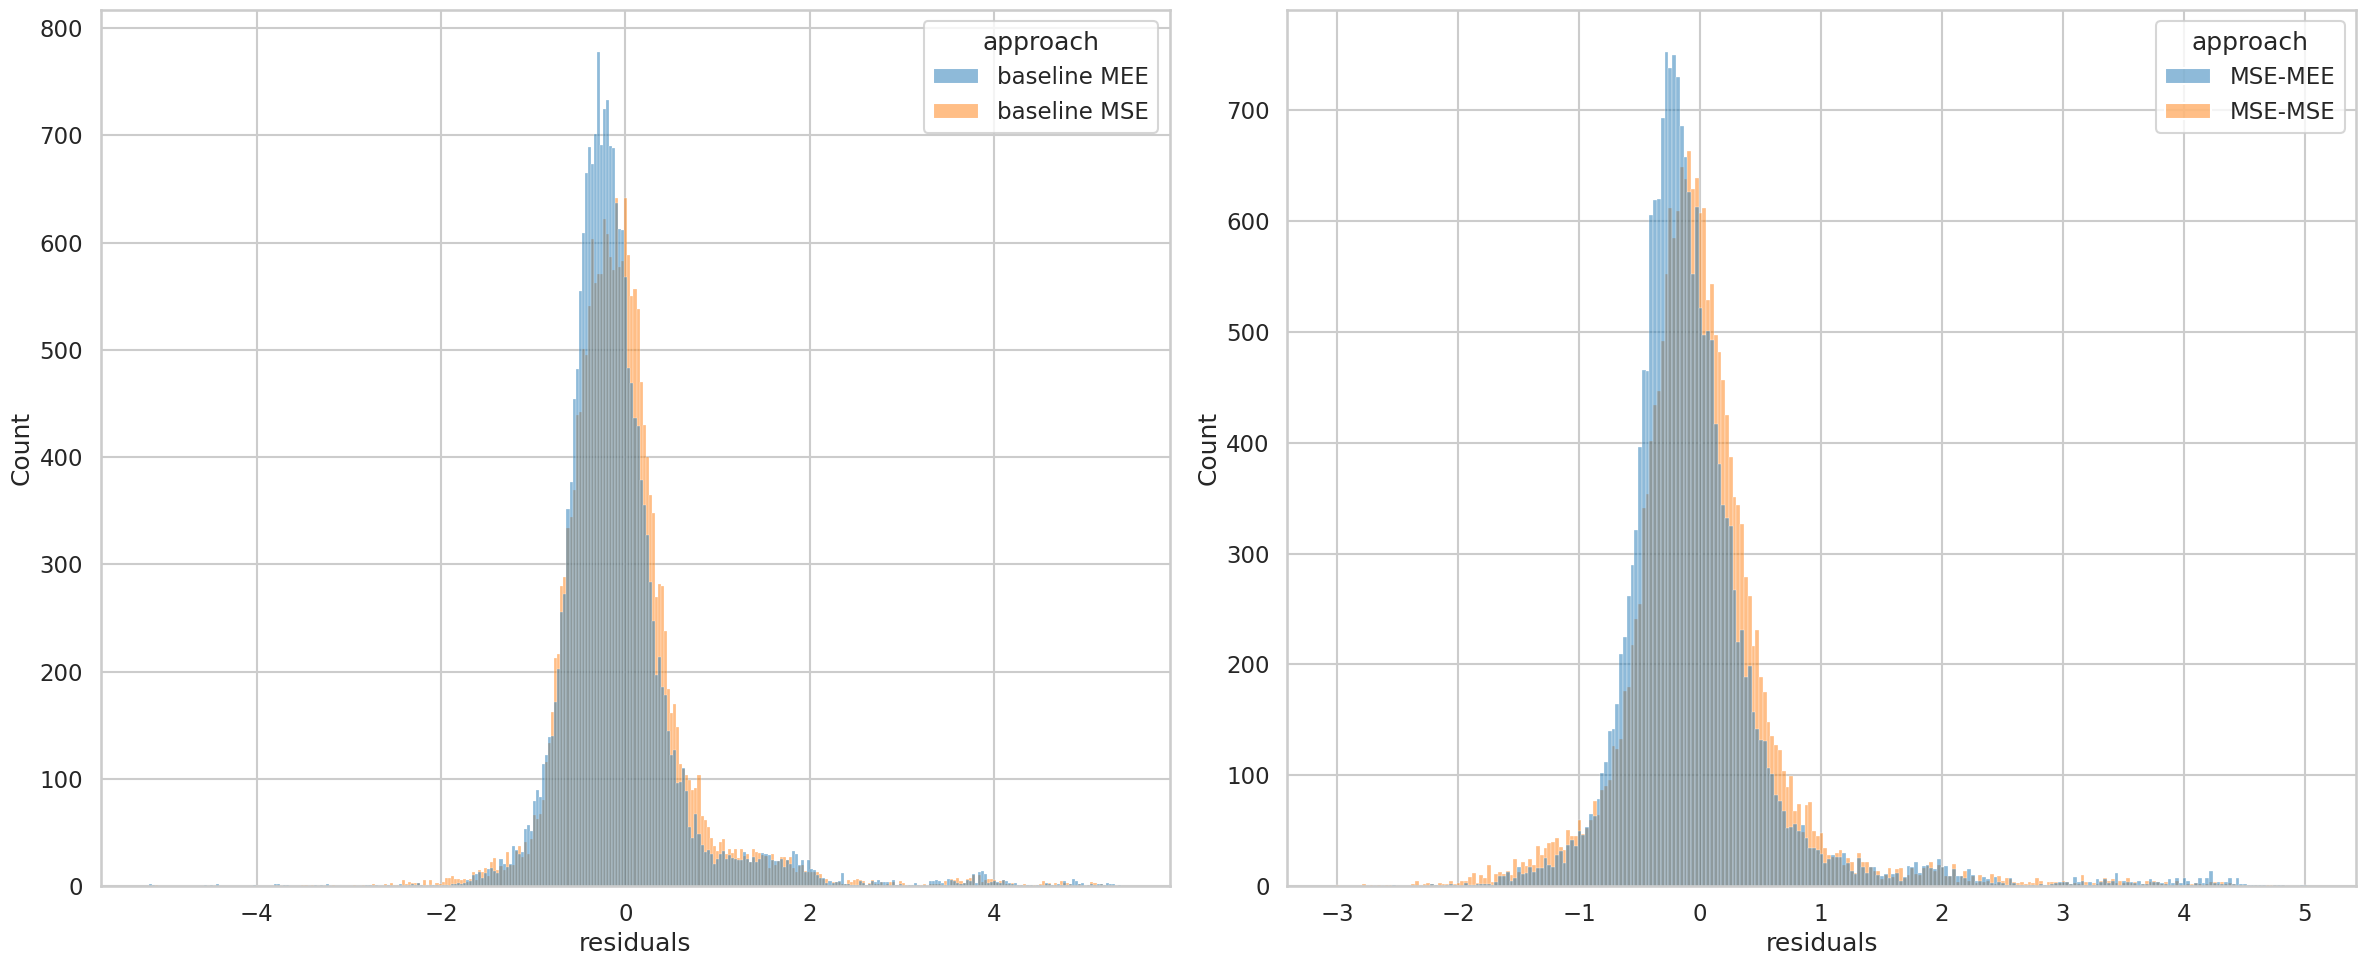

In [23]:
plot_histograms(residual_df, residuals, 'bpm10_tar')

-----------------------------------
# Bike rental 2011

In [24]:
bike11_results = residual_df[residual_df['train_dataset'].str.contains('bike11_tar')]
bike11_results.groupby('approach')['test/mse'].agg(['mean', 'std', 'median'])

,mean,std,median
approach,,,
MEE-MEE,0.161709,0.015185,0.161941
MEE-MSE,0.166123,0.016460,0.167721
MSE-MEE,0.162890,0.012767,0.164506
MSE-MSE,0.162856,0.015274,0.164702
baseline MEE,0.409858,0.032750,0.407884
baseline MSE,0.416299,0.033801,0.409759


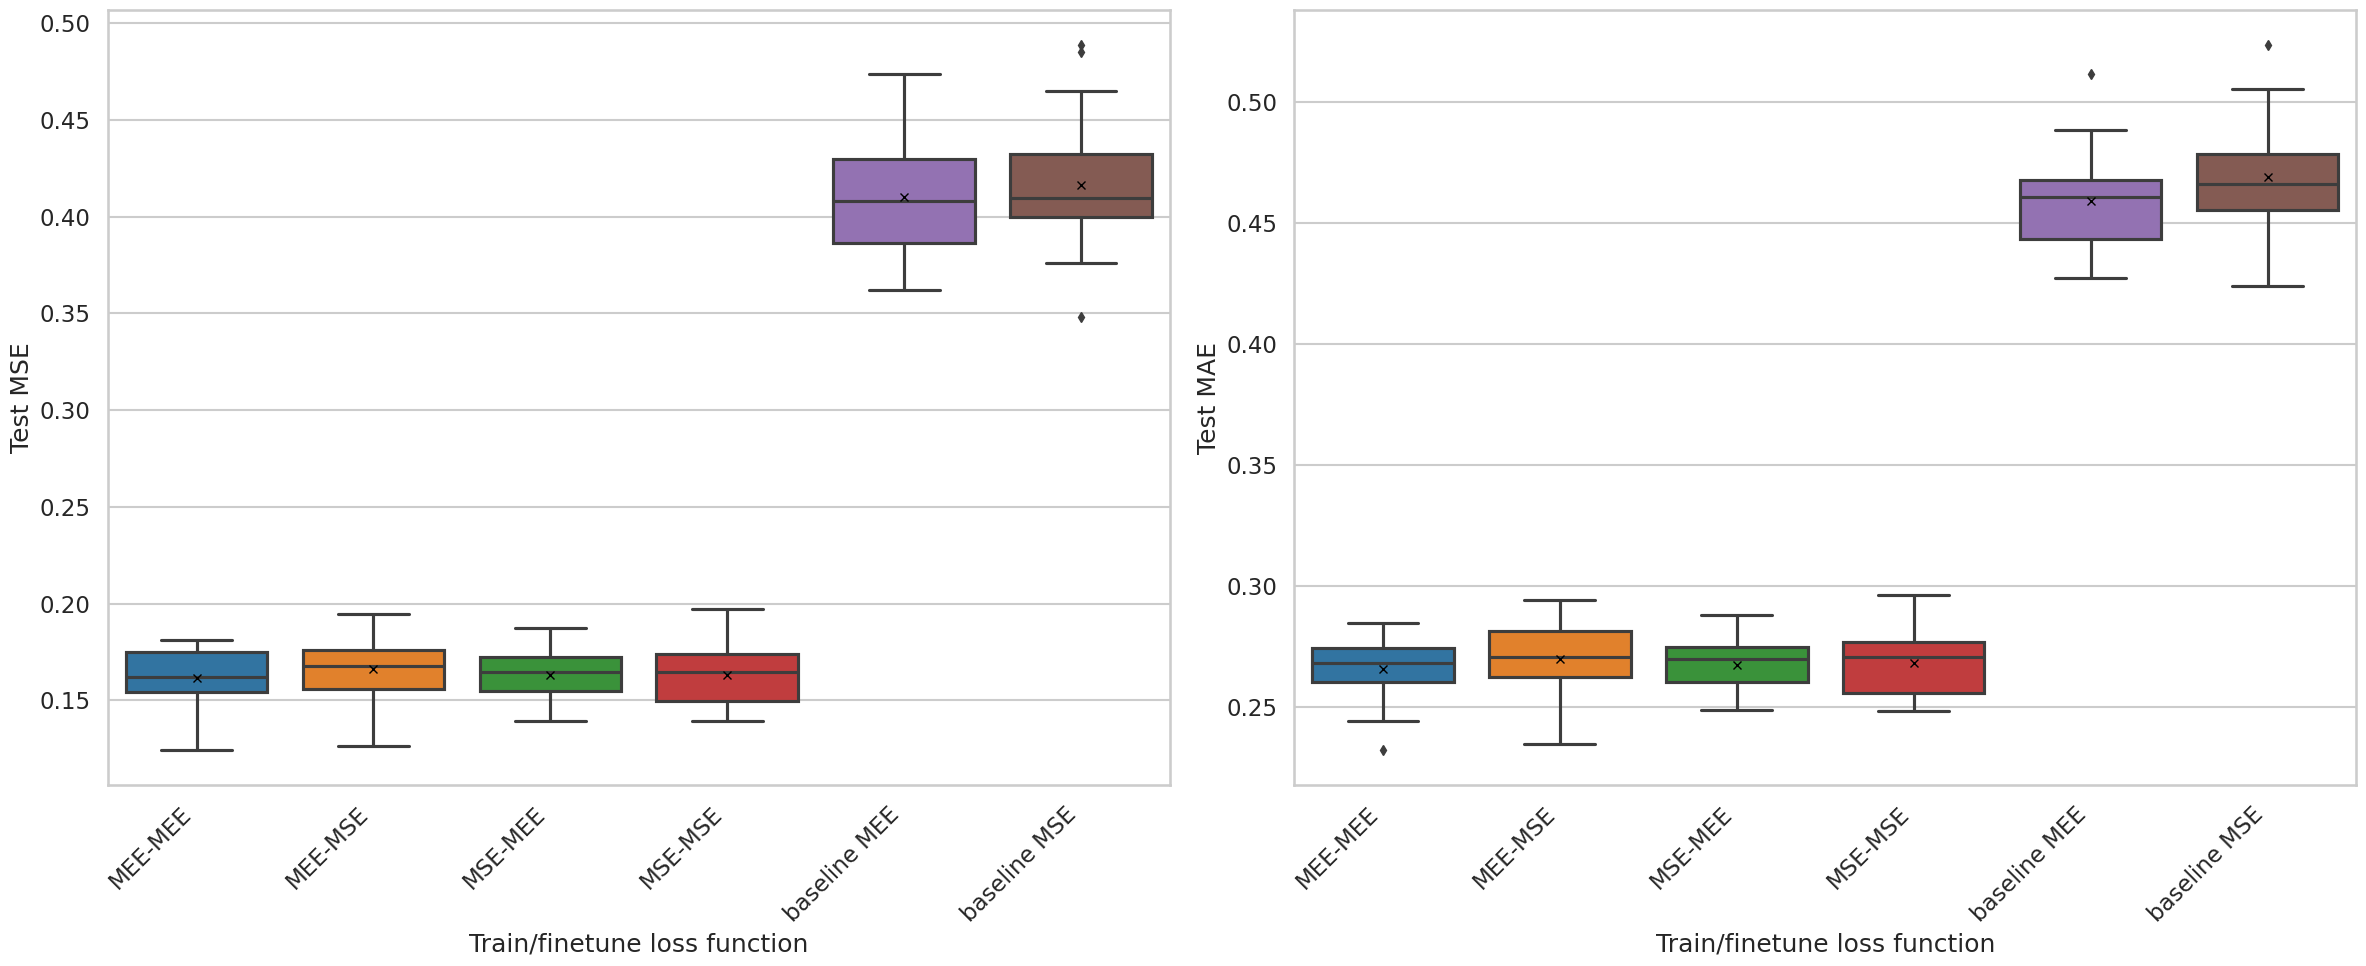

In [25]:
plot_boxplots(residual_df, "bike11_tar")

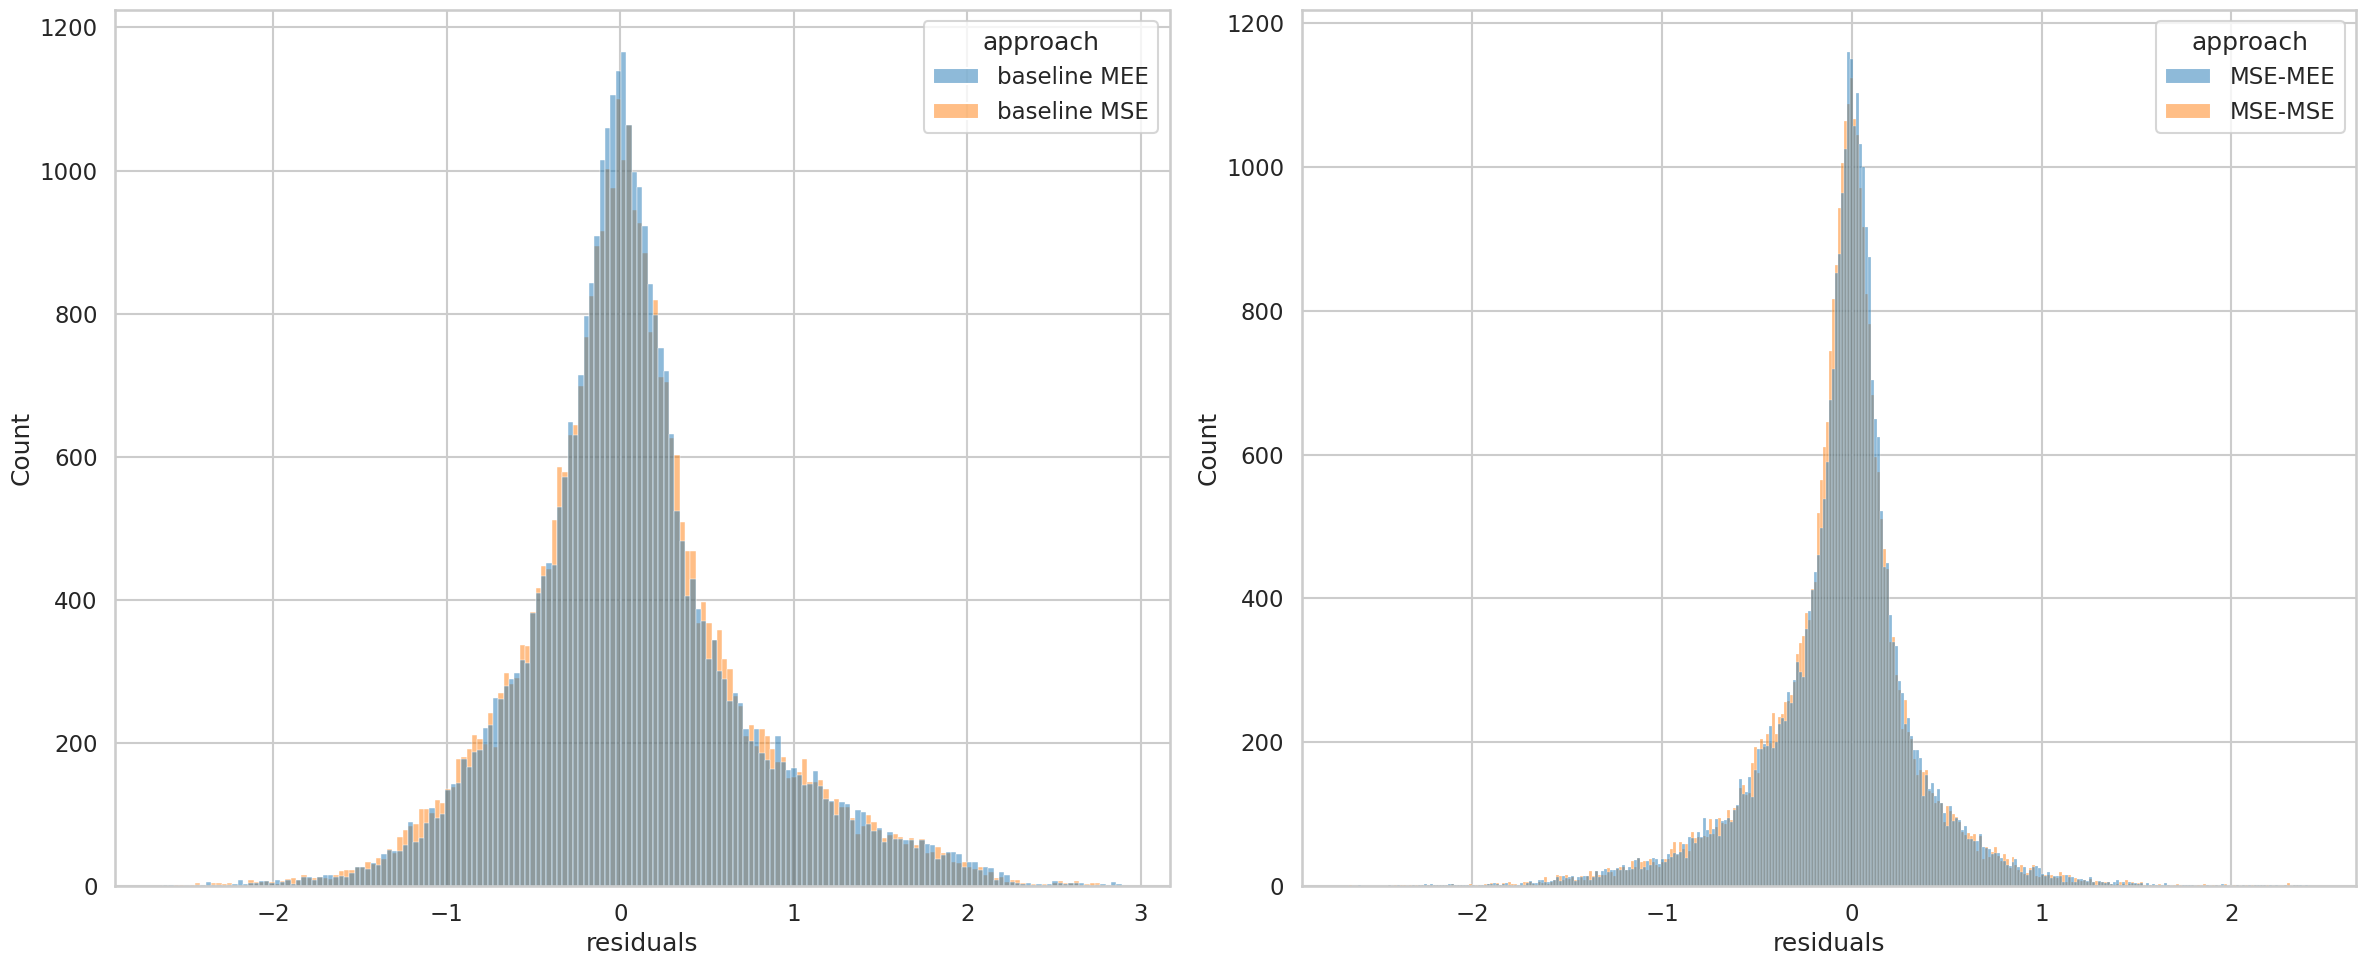

In [26]:
plot_histograms(residual_df, residuals, 'bike11_tar')